# Uso de una red neuronal convolucional para transformar imágenes

# **Hugo Peralta Muñoz**

Este cuaderno utiliza el dataset CIFAR-10 y aplica ruido en forma de puntos aleatorios de colores a las imágenes. Entrenaremos un autoencoder para restaurarlas.

Las secuencias XXXXXXXXX se deben rellenar con el código apropiado.

## Importación de librerías

In [78]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input

from keras.datasets import cifar10

## Carga y preparación de Datos
Cargamos el dataset CIFAR-10 y añadimos ruido en forma de puntos aleatorios.

In [79]:
# Carga el dataset CIFAR-10
# No es necesario cargar las etiquetas porque vamos a hacer una transformación
(x_train, _), (x_test, _) = cifar10.load_data()

In [80]:
# Normaliza los valores de las imágenes al rango [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

In [81]:
# Función que genera ruido en forma de puntos aleatorios a un array de imágenes
def add_random_noise(images_array, num_points):
    noisy_images = images_array.copy()
    for img in noisy_images:
        height, width, _ = img.shape
        for _ in range(num_points):
            # Coordenada x
            x = np.random.randint(width)
            # Coordenada y
            y = np.random.randint(height)
            # Color aleatorio (RGB)
            img[x, y] = np.random.randint(0, 256, 3) / 255.0
    return noisy_images

In [82]:
# Aplica el ruido a los datos (por ej. 300 puntos)
x_train_noisy = add_random_noise(x_train, 300)
x_test_noisy = add_random_noise(x_test, 300)

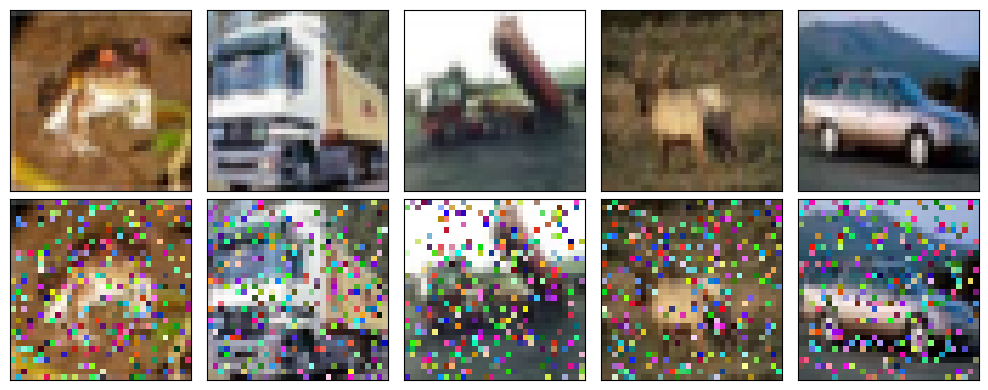

In [83]:
# Muestra algunas imágenes originales y con ruido
n = 5  # Número de imágenes a mostrar
plt.figure(figsize=(10, 4))
for i in range(n):
    # Imagen original
    plt.subplot(2, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])

    # Imagen con ruido
    plt.subplot(2, n, n + i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train_noisy[i])

plt.tight_layout()
plt.show()


## Construcción del Autoencoder
Definimos una arquitectura básica de autoencoder para procesar las imágenes.

In [84]:

# Construcción del modelo autoencoder
model = Sequential([
    # Especifica la entrada ajustada para CIFAR-10
    # Son imágenes de 32x32 con 3 canales de color
    Input(shape=(32, 32, 3), name="Input_layer"),

    # Se aplica el parámetro padding='same' en todas las capas

    # En las capas de convolución, padding='same' hace que
    # se mantenga la resolución.

    # En las capas de max pooling, se reducen de forma explícita las
    # dimensiones de la imagen, aquí padding='same' rellena con ceros los
    # bordes cuando la ventana de pooling no encaja perfectamente en la imagen.

    # Encoder #####################################################

    # Capa de convolución 2D con 32 filtros de convolución de 3x3 y
    # ReLU como función de activación
    Conv2D(32, (3, 3), activation="relu", name="Conv_layer_e1", padding="same"),

    # Capa de max pooling con ventana de 2x2
    MaxPooling2D(2, 2, name="Max_pooling_1", padding="same"),

    # Capa de convolución 2D con 32 filtros de convolución de 3x3 y
    # ReLU como función de activación
    Conv2D(32, (3, 3), activation="relu", name="Conv_layer_e2", padding="same"),

    # Capa de max pooling con ventana de 2x2
    MaxPooling2D(2, 2, name="Max_pooling_2", padding="same"),

    # Decoder ######################################################

    # Capa de convolución 2D con 32 filtros de convolución de 3x3 y
    # ReLU como función de activación
    Conv2D(32, (3, 3), activation="relu", name="Conv_layer_d1", padding="same"),

    # Aumento de resolución (up sampling 2D) para compensar el max pooling
    # con una ventana de 2x2.
    UpSampling2D((2, 2), name="Up_sampling_d1"),

    # Capa de convolución 2D con 32 filtros de convolución de 3x3 y
    # ReLU como función de activación
    Conv2D(32, (3, 3), activation="relu", name="Conv_layer_d2", padding="same"),

    # Aumento de resolución (up sampling 2D) para compensar el max pooling
    # con una ventana de 2x2.
    UpSampling2D((2, 2), name="Up_sampling_d2"),

    # Salida restaurada con 3 canales
    # Capa de convolución 2D con 3 filtros de convolución de 3x3 y
    # sigmoid como función de activación
    Conv2D(3, (3, 3), activation="sigmoid", name="Output_layer", padding="same"),
])

# Compila el modelo con el optimizador adam y la función de pérdida mse
model.compile(optimizer="adam", loss="mse")


In [85]:
# Muestra el resumen del modelo
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_layer_e1 (Conv2D)          │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_pooling_1 (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_layer_e2 (Conv2D)          │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_pooling_2 (MaxPooling2D)    │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_layer_d1 (Conv2D)          │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Up_sampling_d1 (UpSampling2D)   │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_layer_d2 (Conv2D)          │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Up_sampling_d2 (UpSampling2D)   │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Conv2D)           │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

Entrenamos el modelo con las imágenes con ruido como entrada y las originales como objetivo.

In [86]:
validation_percentaje = 0.2
validation_split_index = int(len(x_train) * (1 - validation_percentaje))
x_val = x_train[validation_split_index:] / 255.0
x_val_noisy = x_train_noisy[validation_split_index:]

In [ ]:
# Entrenamiento del autoencoder
# Se entrena el modelo en 10 iteraciones, con un batch size de 128,
# con la mezcla (shuffle) activada y especificando los datos de validación.
model.fit(x_train_noisy, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_val_noisy, x_val))

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - loss: 0.0245 - val_loss: 0.2868
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: 0.0090 - val_loss: 0.2623
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - loss: 0.0079 - val_loss: 0.2808
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - loss: 0.0074 - val_loss: 0.2739
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - loss: 0.0071 - val_loss: 0.2750
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - loss: 0.0068 - val_loss: 0.2747
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - loss: 0.0066 - val_loss: 0.2826
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - loss: 0.0063 - val_loss: 0.2872
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 85ms/step - loss: 0.0061 - val_loss: 0.2810
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - loss: 0.0060 - val_loss: 0.2754


## Evaluación y visualización de resultados

Usamos el modelo entrenado para restaurar las imágenes con ruido y comparar los resultados.

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step


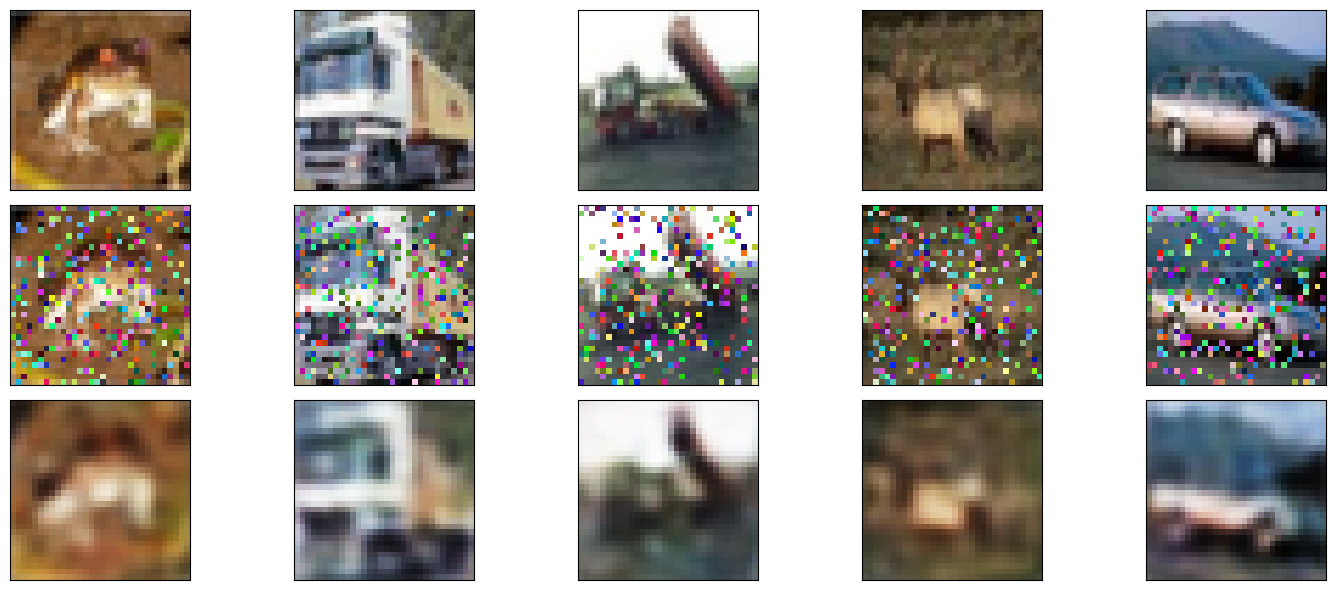

In [88]:
# Usa el modelo para limpiar imágenes con ruido del conjunto de pruebas
decoded_images = model.predict(x_train_noisy)

# Muestra algunas imágenes originales, con ruido y restauradas
n = 5  # Número de imágenes a mostrar
plt.figure(figsize=(15, 6))
for i in range(n):
    # Imagen original
    plt.subplot(3, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])

    # Imagen con ruido
    plt.subplot(3, n, i + 1 + n)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train_noisy[i])

    # Imagen restaurada
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(decoded_images[i])

plt.tight_layout()
plt.show()

## Eliminación de ruido de una imagen externa

Cargamos una imagen externa al dataset que tiene ruido para comprobar cómo funciona nuestro autoencoder.

In [89]:
# Importa las funciones load_img (carga una imagen) y img_to_array (convierte una imagen en un array)
from keras.utils import load_img, img_to_array

In [90]:
# Pide la ruta de la imagen al usuario

# CONSEJO: Añadir la imagen original con la que se hacen los testeos, viene en el zip
image_path = input("Introduzca la ruta de la imagen a procesar: ")

In [172]:
# Ajusta la imagen al tamaño esperado por el modelo
# En mi caso para las pruebas: 
# image_path = "D:\CEIABD\CEIABD\Inteligencia artificial\Tema 13. Redes Neuronales Convolucionales\pingu.png"

# IMPORTANTE: El target size lo dejo en el tamaño de la imagen que cogi originalmente y trabaja bien el modelo
# Si cambias a (32, 32) tambien lo hace bien, pero se muestra borrosa la salida
image = load_img(image_path, target_size=(347, 347), color_mode="rgb")

In [178]:
# Normaliza al rango [0, 1]
image_array = img_to_array(image)
image_array = image_array / 255.0

image_array.shape

(347, 347, 3)

In [179]:
# Crear la imagen añadida con ruido
# Lo añado como array ya que lo que espera es un array de varias imagenes, en este caso solo tenemos 1
noisy_image = add_random_noise([image_array], 20000)[0]

In [180]:
# Expande en una dimensión para indicar el batch size
# Se indica la imagen cuyas dimensiones se van a expandir y el eje (axis=0)
# Si antes, la imagen tenía las dimensiones (32, 32, 3), después de expandir
# las dimensiones, debería tener (1, 32, 32, 3) porque se va a procesar una
# sola imagen.
print(noisy_image.shape)
noisy_image = np.expand_dims(noisy_image, axis=0)
print(noisy_image.shape)

(347, 347, 3)
(1, 347, 347, 3)


In [181]:
# Pasa la imagen por el modelo para que le quite el ruido
restored_image = model.predict(noisy_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


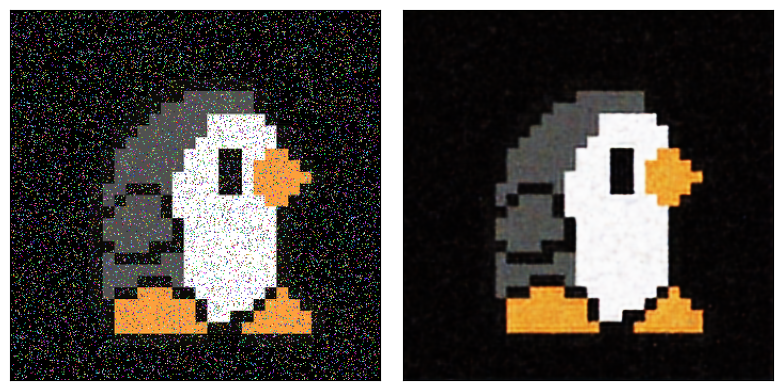

In [182]:
# Muestra las imágenes con ruido y restaurada
plt.figure(figsize=(8, 4))

# Imagen con ruido
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(noisy_image.squeeze()) # Este metodo elimina las axis con valor 1, es decir, elimina el batch inicial

# Imagen restaurada
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(restored_image.squeeze())

plt.tight_layout()
plt.show()

## Conclusiones

En este ejemplo, hemos utilizado el dataset CIFAR-10 para entrenar un autoencoder que elimina ruido de imágenes en forma de puntos aleatorios. Puedes experimentar con diferentes arquitecturas, niveles de ruido y datasets para mejorar los resultados.

Este modelo trabaja bien en las dimensiones que sean originales del modelo, el modelo fue entrenado por imagenes de $32 x 32$, aunque funciona bien en esas dimensiones, es una resolución muy baja para imágenes reales o de un escalado mayor. Por ello, las imágenes reales que pasaremos al modelo para que elimine el ruido serán de dimensiones mayores, esto puedes cambiarlo en el paso anterior, donde tenemos que `target_size=(347, 347)`, esto es porque la imagen a la que añado ruido y luego elimino es de estas dimensiones, puedes cambiar este ejemplo por otro y cambiar a la dimensión normal de la imagen.

Podemos entender de esto, que aunque la red neuronal se entrenase con imágenes de un tamaño en específico y que quizás sea más eficaz ahí, al escalarlo también hace bien la función de eliminar el ruido de la imagen, con lo cual no tenemos que perder la calidad inicial que tenía esta misma.